In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import argparse, logging, string, random, sys, os, pdb
from datetime import datetime
import warnings, shutil
import pdb
from get_mods import DART_Net, sep_ijkl_dataset, load_checkpoint

## Argparser to read config file, restart needs to be given to load saved model

In [2]:
#define command line arguments
parser = argparse.ArgumentParser(fromfile_prefix_chars='@')
parser.add_argument("--restart", type=str, default=None,  help="restart training from a specific folder")
parser.add_argument("--dataset", type=str,   help="file path to dataset")
parser.add_argument("--batch_size", type=int, help="batch size used per training step")
parser.add_argument("--adam_lr", default=0.0001, type=float, help="learning rate used by the optimizer")
parser.add_argument("--decay_steps", type=int, help="decay the learning rate with patience of N steps by decay_rate")
parser.add_argument("--max_epochs", type=int, help="Maximum number of epoch")
parser.add_argument("--seed", type=int, help="seed for split")
parser.add_argument("--lh", type=int, help="Number of hidden layers")
parser.add_argument("--lo", type=int, help="Number of outfut feature layers")
parser.add_argument("--li2", type=int, help="Number of interaction feature layers")
parser.add_argument("--li3", type=int, help="Number of interaction feature layers")
parser.add_argument("--li4", type=int, help="Number of interaction feature layers")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#if no command line arguments are present, config file is parsed
config_file='config.txt'
if len(sys.argv) == 1 or sys.argv[1] == "-f":
    if os.path.isfile(config_file):
        args = parser.parse_args(["@"+config_file])
    else:
        args = parser.parse_args(["--help"])
else:
    args = parser.parse_args()

if args.restart is None:
    print("No restart given cannot load model")
    sys.exit()
else:
    directory = "runs/" + args.restart
    print("Model loaded from directory ", directory)
    config_file = directory + '/config.txt'
    args = parser.parse_args(["@"+config_file])

log_dir = os.path.join(directory, 'logs')
if not os.path.exists(log_dir):
    print("log directory not found\n")
    sys.exit()

fname = directory + "/test"
if os.path.isfile(fname+".log"):
    os.remove(fname+".log")

Model loaded from directory  runs/20201216072707_Ij2TYXpT


## Define model 

In [3]:
DART_model = DART_Net(args.lh, args.lo, args.li2, args.li3, args.li4).to(device)
logging.info(DART_model)

def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

DART_model.apply(init_params)

DART_Net(
  (fi1): Linear(in_features=3, out_features=128, bias=True)
  (fi2): Linear(in_features=128, out_features=128, bias=True)
  (fj1): Linear(in_features=3, out_features=128, bias=True)
  (fj2): Linear(in_features=128, out_features=128, bias=True)
  (fk1): Linear(in_features=3, out_features=128, bias=True)
  (fk2): Linear(in_features=128, out_features=128, bias=True)
  (fl1): Linear(in_features=3, out_features=128, bias=True)
  (fl2): Linear(in_features=128, out_features=128, bias=True)
  (inter1): Linear(in_features=128, out_features=256, bias=True)
  (inter2): Linear(in_features=256, out_features=128, bias=True)
  (inter3): Linear(in_features=128, out_features=32, bias=True)
  (inter4): Linear(in_features=32, out_features=1, bias=True)
  (mask): Linear(in_features=128, out_features=128, bias=False)
)

## Create dataloader

In [4]:
test_set = sep_ijkl_dataset(args.dataset)
test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

## Testing loop

In [5]:
criterion = torch.nn.L1Loss()
test_mae = []
num_epochs = args.max_epochs

def test(variable_model, testloader):
    mae = torch.nn.L1Loss()
    rmse = torch.nn.MSELoss()
    pred_energy = torch.tensor([], device="cuda")
    real_energy = torch.tensor([], device="cuda")
    cluster_size = torch.tensor([], device="cuda")
    variable_model.eval()
    with torch.no_grad():
        for batch in testloader:
            energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1).squeeze()
            pred_energy = torch.cat((pred_energy, energy))
            real_energy = torch.cat((real_energy, batch["energy"]))
            cluster_size = torch.cat((cluster_size, batch["atm_i"][:,0].sum(axis=1)))
        results = torch.stack((cluster_size, real_energy, pred_energy), axis=1)
        test_loss = mae(pred_energy, real_energy)
        rmse_loss = torch.sqrt(rmse(pred_energy, real_energy))
        return results, test_loss, rmse_loss

## Restore/load saved model

In [6]:
restore_path = os.path.join(log_dir + "/last.pth.tar")
checkpoint = load_checkpoint(restore_path, DART_model)
start_epoch = checkpoint["epoch"]

## Lets start testing

In [7]:
results, test_mae, test_rmse = test(DART_model, test_loader)
print("Test MAE: {:.4f} kcal/mol\nTest RMSE: {:.4f} kcal/mol".format(test_mae.item(), test_rmse.item()))

Test MAE: 3.1943 kcal/mol
Test RMSE: 4.0826 kcal/mol


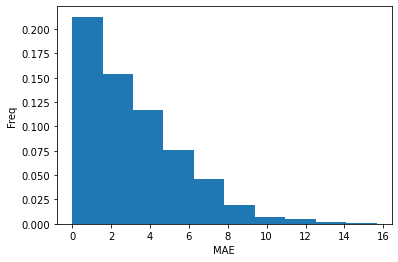

In [8]:
results = results[results[:,0].argsort()].cpu().numpy()
plt.hist(abs(results[:,1]-results[:,2]), density=True)
plt.xlabel("MAE")
plt.ylabel("Freq")
plt.show()

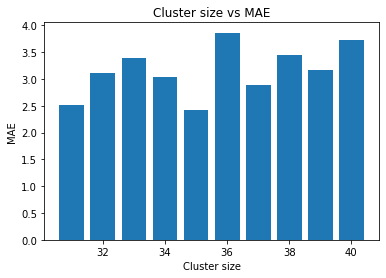

In [9]:
some_res = np.split(results[:,1:], np.unique(results[:, 0], return_index=True)[1][1:])
diff = [abs(i[:,0]-i[:,1]).mean() for i in some_res]
plt.title("Cluster size vs MAE")
plt.bar(np.arange(31, 41), diff, label='Training Loss')
plt.xlabel("Cluster size")
plt.ylabel("MAE")
plt.show()

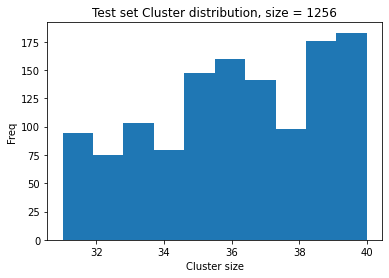

In [10]:
trainset = test_set[:]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Test set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=10)
plt.show()
# plt.savefig("cluster_distribution_trainset.png", bbox_inches='tight')